## This is a Julia version of the code for Einstein_Scalar_field

See paper: *On free evolution of self gravitating, spherically symmetric waves.*

Equations in notes.ipynb

In [31]:
using OrdinaryDiffEq
using SummationByPartsOperators
#using DifferentialEquations
using Plots
using LinearAlgebra
#using BandedMatrices
using Printf


In [32]:
include("aux_functions_IR.jl") # here is where the functions are stored.

b_b (generic function with 1 method)

In [33]:
N = 4001 #grid steps
x_i = 1.0; x_f = 100.0 #region 
dx = (x_f-x_i)/(N-1)
U = 5 #number of fields (f,g,h,χ_+,χ_-)

u0 = zeros(N*U) # for the initial data
du = zeros(N*U) # for the time derivatives
C = ones(2N) # for the constraints

#order 6/8 are not working, I get instabilities. Problems with the eigenvalues too big? Does not seem to be so.

#D = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=8, xmin=x_i, xmax=x_f, N=N)
D = derivative_operator(MattssonAlmquistVanDerWeide2018Accurate(), derivative_order=1, accuracy_order=8, xmin=x_i, xmax=x_f, N=N)
#D = derivative_operator(MattssonAlmquistCarpenter2014Optimal(), derivative_order=1, accuracy_order=4, xmin=x_i, xmax=x_f, N=N)
#D = derivative_operator(Mattsson2017(), derivative_order=1, accuracy_order=8, xmin=x_i, xmax=x_f, N=N)


# one can the get the grid for the D, this is important when the operator has non-uniform grid.
x = SummationByPartsOperators.grid(D)

# the dissipation operator correponding to D
Δ = dissipation_operator(D)
#Δ = 1.0
dT = 1.0*D.Δx
@show dx - D.Δx
σ = -0.0 # dissipation strength

dx - D.Δx = -8.426714607250724e-6


-0.0

In [34]:
# put some boundary data

sinusoidal = false
bump = true

#sinusoidal pulse
# (t<tf) ? A*sin(ω*t)*exp(-t/τ) : 0.0
if sinusoidal
    p_sb = (0.10, π/2, 5.0, 10) #A = 0.10; ω = 2π; τ = 5.0; tf = 10; A=1 generates a black hole, A=0.1 just a bounce
    p = (D, Δ, σ, x, s_b, p_sb) # UNCOMMENT TO USE
end

#polynomial bump
#(t0 - t)*(t - t1) >= 0 ? A*(t0 - t)^(order)*(t - t1)^(order)*(2/(t0-t1))^(2order) : 0.0
# A=1 generates a black hole, A=0.1 just a bounce
if bump
    p_bb = (0.1, 1, 9, 8) # (A, t0, t1, order)
    p = (D, Δ, σ, x, b_b, p_bb)
end

f = @view u0[1:N]
g = @view u0[N+1:2N]
h = @view u0[2N+1:3N]
χ₊ = @view u0[3N+1:4N]
χ₋ = @view u0[4N+1:5N]

f .= 1.0;
g .= 1.0;
#rest set to zero

D*f

Δ*f

p

(SBP first-derivative operator of order 8 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Almquist, van der Weide (2018) 
  Boundary optimized diagonal-norm SBP operators ('Accurate'). 
  Journal of Computational Physics 374, pp. 1261-1266., SBP 8-derivative dissipation operator of order 2 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Svärd, Nordström (2004) 
  Stable and Accurate Artificial Dissipation. 
  Journal of Scientific Computing 21.1, pp. 57-79. 
See also (first and second derivatives) 
  Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., -0.0, [1.0, 1.0094375533277282, 1.0294614158110487, 1.0556477830714122, 1.082180277643923, 1.1069387043585304, 1.1316971310731376, 1.156455557787745, 1.1812139845023522, 1.2059724112169594  …  99.79402758878304, 99.81878601549765, 99.84354444221225, 99.8683028689

The boundary values

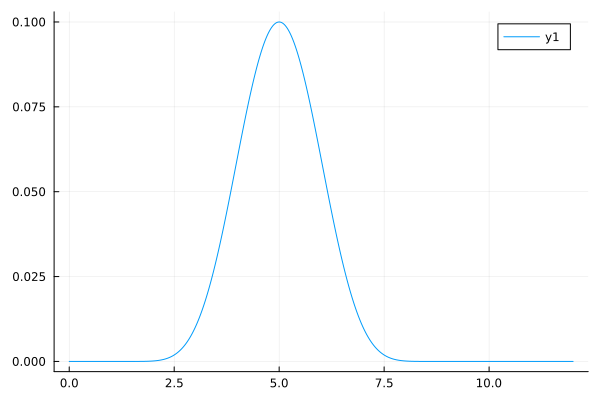

In [35]:
tt = 0:0.01:12
if bump
plot(tt,tt->b_b(tt,p_bb))
else
plot!(tt,tt->s_b(tt,p_sb))
end

In [36]:
T=220
M = 440 # saving steps
prob = ODEProblem(F!,u0,(0.0,T),p);
#alg = ORK256()
#alg = RK4()
alg = Tsit5()
#sol = solve(prob,alg,dt=dT*0.50,adaptive=false, saveat=T/M);#,save_everystep=false);
sol = solve(prob,alg,dtmax=dT*0.50, saveat=T/M);#,adaptive=false);#,save_everystep=false);

The geometry near the left boundary.

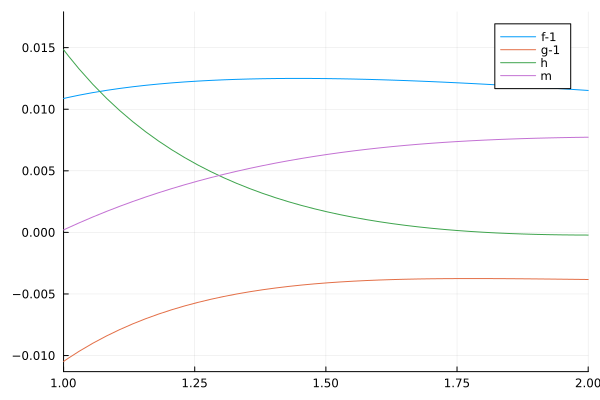

In [37]:
t = 104
plot(x,sol(t)[1:N].-1.0, label = "f-1"
#, ylim=(-0.00002,0.000020)
, xlim=(1,2)
)
#plot!(x,3.4./x)
plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
plot!(x,sol(t)[2N+1:3N], label = "h")
plot!(x,m(x,sol(t)[1:N],sol(t)[N+1:2N]),label ="m")

The fields near the left boundary at different times.

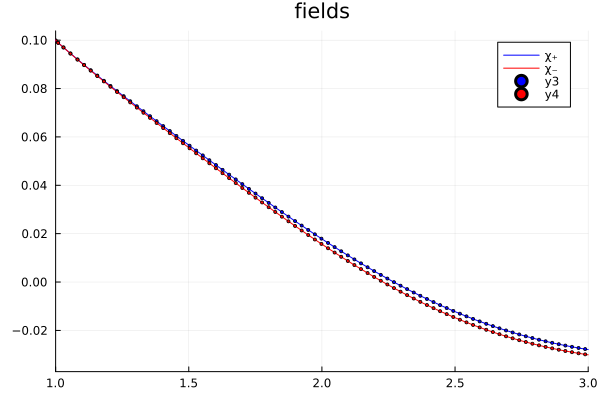

In [38]:
t = 104
plot(title = "fields")
plot!(x,sol(t)[3N+1:4N], label = "χ₊", c=:blue
,xlim = (1,3)
#,ylim = (-0.001,0.001)
)
plot!(x,sol(t)[4N+1:5N], label = "χ₋", c=:red)
scatter!(x,sol(t)[3N+1:4N],ms=1.7, c=:blue)
scatter!(x,sol(t)[4N+1:5N],ms=1.7, c=:red)

Constraint violation plot

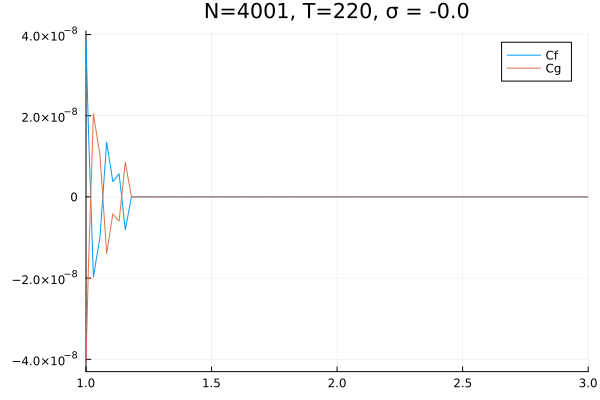

In [39]:
t = 105
constraints!(C,sol(t),D)
plot(title = "N=$N, T=$T, σ = $σ")
plot!(x,C[1:N], label = "Cf"
, xlim = (1.0,3.0)
#, ylim = (-0.01,0.01)
)
plot!(x,C[N+1:2N], label = "Cg")
#png("Images/Constraints_A01"*"MAWA_8_T$(T)_N$(N)_S_0p0dT0p5p0")

We also compute the constraint norm outside the black - hole, when it forms. In general the constraint violation inside the hole is quite big.

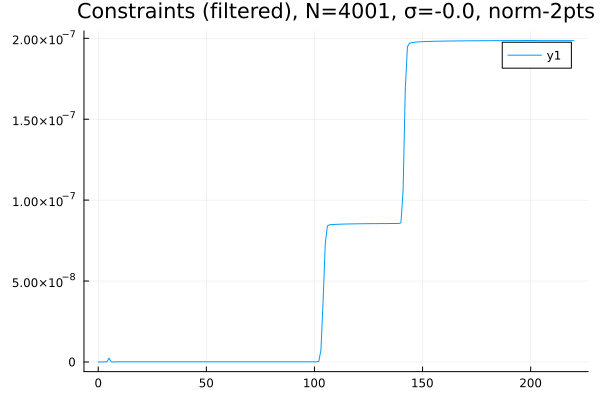

In [40]:
CC(t) = norm(constraints_filter!(C,sol(t),D)[1:end])
plot(0:T,t->CC(t), title="Constraints (filtered), N=$N, σ=$σ, norm-2pts"
#, ylim=(0,0.0002)
)
#png("Images/Constraints_A11"*"_MAWA_8_N$(N)_S_0p0_dT0p5_c2-2")

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/fghm_A01_B_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/fghm_A01_B_fps5.gif")
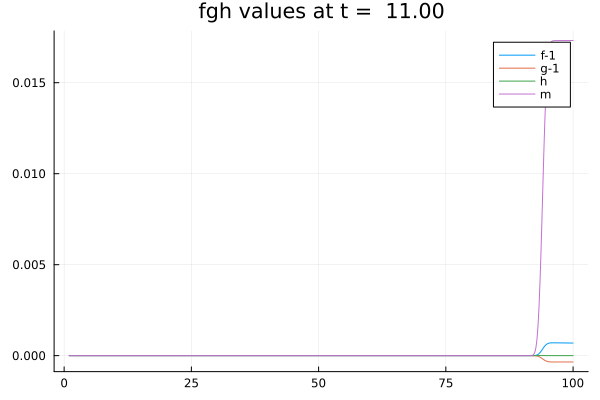

In [41]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title=@sprintf("fgh values at t = %6.2f",t)
    #,ylim=(-0.01,0.01)
    )
    #@sprintf("\$t = %6.2f \$", sol.t[idx])
    plot!(x,sol(t)[1:N].-1.0, label = "f-1")
    plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
    plot!(x,sol(t)[2N+1:3N], label = "h")
    plot!(x,m.(x,sol(t)[1:N],sol(t)[N+1:2N]),label ="m")
end

gif(anim, "fghm_A01_B_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/scalar_A01_B_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/scalar_A01_B_fps5.gif")
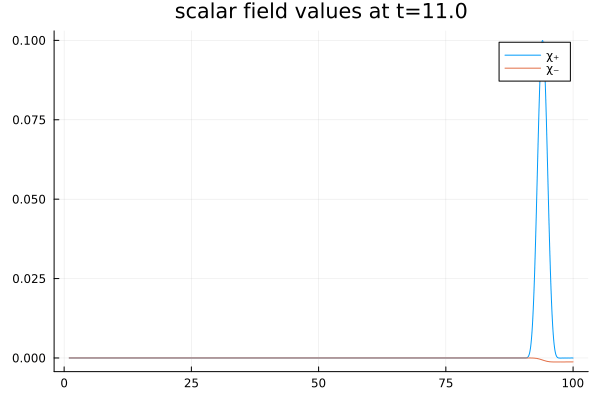

In [42]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="scalar field values at t=$t"
    #, ylim=(-1,1)
    )
    plot!(x,sol(t)[3N+1:4N], label = "χ₊")
    plot!(x,sol(t)[4N+1:5N], label = "χ₋")
end

gif(anim, "scalar_A01_B_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/constraints_A01_B_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/constraints_A01_B_fps5.gif")
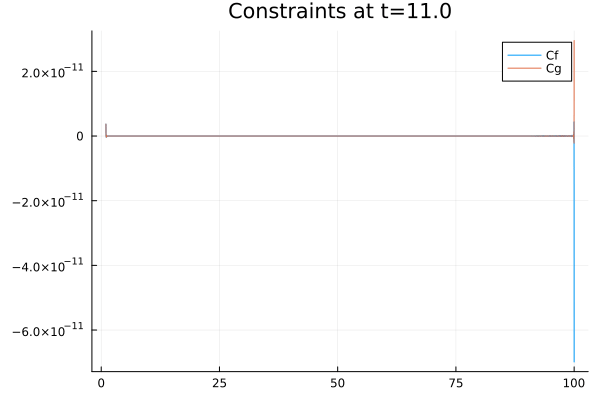

In [43]:
C = zeros(2N)
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="Constraints at t=$t"
    #, ylim=(-0.001,0.001)
    )
    constraints!(C,sol(t),D)
    plot!(x,C[1:N], label = "Cf")
    plot!(x,C[N+1:2N], label = "Cg")
end

gif(anim, "constraints_A01_B_fps5.gif", fps = 5)

In [44]:
Head_Z = [-24.0/17.0   59.0/34.0  -4.0/17.0  -3.0/34.0        0.0       0.0 
                 -1.0/2.0         0.0    1.0/2.0        0.0        0.0       0.0 
                 4.0/43.0  -59.0/86.0        0.0  59.0/86.0  -4.0/43.0       0.0 
                 3.0/98.0         0.0 -59.0/98.0        0.0  32.0/49.0 -4.0/49.0
                ]
                

4×6 Matrix{Float64}:
 -1.41176     1.73529   -0.235294  -0.0882353   0.0         0.0
 -0.5         0.0        0.5        0.0         0.0         0.0
  0.0930233  -0.686047   0.0        0.686047   -0.0930233   0.0
  0.0306122   0.0       -0.602041   0.0         0.653061   -0.0816327